In [16]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from datasets import Dataset
from torch.utils.data import DataLoader

In [2]:
model_body = SentenceTransformer('BAAI/bge-large-en')
model_head = RandomForestClassifier(max_depth=8, random_state=20)

model = SetFitModel(
        model_body=model_body,
        model_head=model_head,
        multi_target_strategy=None,
        l2_weight=1e-2,
        normalize_embeddings=False)

In [3]:
prompts_train = pd.read_csv("data/prompts_train.csv")
summaries_train = pd.read_csv("data/summaries_train.csv")

df = summaries_train.merge(prompts_train, how="left", on="prompt_id")

In [4]:
df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [5]:
content_target_labels, conten_boundaries = pd.cut(df['content'], bins=10, retbins =True, labels = [1,2,3,4,5,6,7,8,9,10])
df['content_class'] = content_target_labels.values.tolist()

wording_target_labels, wording_boundaries = pd.cut(df['wording'], bins=10, retbins =True, labels = [1,2,3,4,5,6,7,8,9,10])
df['wording_class'] = wording_target_labels.values.tolist()

content_train_df, content_test_df = train_test_split(df, test_size = 0.25, stratify=df['content_class'])

In [6]:
content_train_df['q_and_text'] = content_train_df['text'].apply(lambda x: re.sub(r"\s+", ' ', x)) + content_train_df['prompt_question'].apply(lambda x: re.sub(r"\s+", ' ', x))
content_test_df['q_and_text'] = content_test_df['text'].apply(lambda x: re.sub(r"\s+", ' ', x)) + content_test_df['prompt_question'].apply(lambda x: re.sub(r"\s+", ' ', x))

In [7]:
content_train_df = content_train_df.sample(frac = 0.6)
len(content_train_df)

3224

In [8]:
trainer = SetFitTrainer(
    model=model,
    train_dataset= Dataset.from_pandas(content_train_df[['q_and_text', 'content_class']]),
    eval_dataset=Dataset.from_pandas(content_test_df[['q_and_text', 'content_class']]),
    loss_class=CosineSimilarityLoss,
    batch_size=6,
    num_iterations=5, 
    num_epochs=2,
    column_mapping={"q_and_text": "text", "content_class": "label"},
    metric=classification_report,
    use_amp=True,
    warmup_proportion = 0.05
)

In [9]:
trainer.train()

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 32240
  Num epochs = 2
  Total optimization steps = 10748
  Total train batch size = 6


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5374 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5374 [00:00<?, ?it/s]

In [17]:
eval_data = Dataset.from_pandas(content_test_df[['q_and_text', 'content_class']])
train_data = Dataset.from_pandas(content_train_df[['q_and_text', 'content_class']])

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
eval_dataloader = DataLoader(eval_data, batch_size=64, shuffle=False)

train_pred = []

for batch in tqdm(train_dataloader):
    pred = model(batch['q_and_text'])
    train_pred.append(pred)

train_pred = np.hstack(train_pred)

print(classification_report(content_train_df['content_class'].values,  train_pred))

eval_pred = []

for batch in tqdm(eval_dataloader):
    pred = model(batch['q_and_text'])
    eval_pred.append(pred)

eval_pred = np.hstack(eval_pred)

print(classification_report(content_test_df['content_class'].values,  eval_pred))

100%|██████████| 51/51 [00:46<00:00,  1.09it/s]


              precision    recall  f1-score   support

           1       0.91      0.91      0.91       459
           2       0.90      0.92      0.91       526
           3       1.00      0.97      0.99       744
           4       1.00      1.00      1.00       673
           5       0.94      0.96      0.95       307
           6       0.85      0.78      0.81       226
           7       0.71      0.85      0.78       179
           8       0.86      0.41      0.56        61
           9       0.53      0.76      0.62        38
          10       0.89      0.73      0.80        11

    accuracy                           0.93      3224
   macro avg       0.86      0.83      0.83      3224
weighted avg       0.93      0.93      0.93      3224



100%|██████████| 28/28 [00:26<00:00,  1.06it/s]

              precision    recall  f1-score   support

           1       0.74      0.49      0.59       253
           2       0.44      0.56      0.49       298
           3       0.55      0.57      0.56       420
           4       0.59      0.53      0.56       380
           5       0.39      0.55      0.45       173
           6       0.35      0.29      0.32       115
           7       0.43      0.42      0.43        95
           8       0.33      0.06      0.11        32
           9       0.35      0.40      0.37        20
          10       0.50      0.33      0.40         6

    accuracy                           0.51      1792
   macro avg       0.47      0.42      0.43      1792
weighted avg       0.53      0.51      0.51      1792



In [19]:
model.save_pretrained('setfit_content_class')

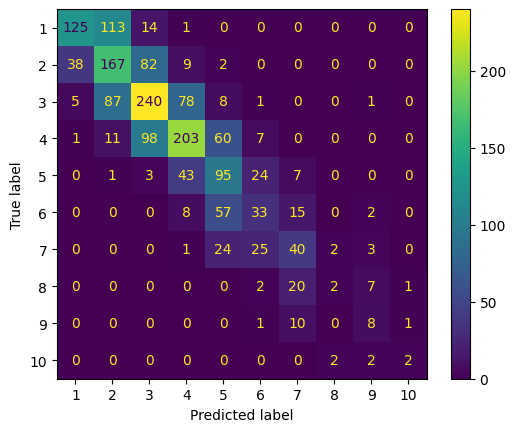

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(content_test_df['content_class'].values,  eval_pred)
disp  = ConfusionMatrixDisplay(cm, display_labels = [1,2,3,4,5,6,7,8,9,10])
disp.plot();